Import necessary modules:

In [1]:
import numpy as np
import pandas as pd
import datetime

import os
import requests
import zipfile

Electric Reliability Council of Texas (ERCOT) keeps records of their electric generation. As of Feb 19 2020, this file is available at [ERCOT](http://www.ercot.com/gridinfo/generation). The dataset used in this demonstration, available as a link to a zip file, is the [Fuel Mix Report: 2007-2019](http://www.ercot.com/content/wcm/lists/181766/FuelMixReport_PreviousYears.zip). This dataset reports actual generation by fuel type for each 15-minute settlement interval, as well as totals by month and year-to-date.

Function download:

In [3]:
def master_wind_energy_data_processing():
    '''
    This is the master function that would process all the ERCOT energy data
    '''
    download_ERCOT_data()
    export_clean_wind_generation_data()
    delete_file()
    return

In [4]:
def filename_convention(year):
    '''
    This function gives the corresponding excel file name from ERCOT dataset
    Arguments:
        year: year, the year of the data is taken from.
    '''
    if year in list(range(2017,2020)):
        filename = 'IntGenbyFuel'+str(year)+'.xlsx'
    elif year in list(range(2013,2016)):
        filename = 'IntGenByFuel'+str(year)+'.xls'
    elif year == 2016:
        filename = 'IntGenByFuel'+str(year)+'.xlsx'
    return filename

In [5]:
def download_ERCOT_data():
    '''
    This function downloads ERCOT dataset zipfile and unzip necessary files.
    '''
    zip_name = 'FuelMixReport_PreviousYears.zip'
    if os.path.exists(zip_name):
        print(zip_name + " exists!")
    else:
        print(zip_name + " does not exist")
        print('downloading: '+ zip_name)
        url = 'http://www.ercot.com/content/wcm/lists/181766/FuelMixReport_PreviousYears.zip'
        req = requests.get(url)
        assert req.status_code == 200,'download failed' # if the download failed, this line will generate an error
        with open(zip_name, 'wb') as file:
            file.write(req.content)
    # Unzip all related files:
    assert zipfile.is_zipfile(zip_name), str(zip_name)+' is not recognized as a zipfile. Check for file corruption.'
    zf = zipfile.ZipFile(zip_name)
    for year in list(range(2013,2020)):
        filename = filename_convention(year)
        assert filename in zf.namelist(), str(filename)+' is not found in the zipfile. Check function filename_convention.'
        if os.path.exists(filename):
            print(filename + " exists!")
        else:
            zf.extract(filename)
    return

In [6]:
def delete_file():
    '''
    This function deletes the unnessary files created in the process.
    '''
    zip_name = 'FuelMixReport_PreviousYears.zip'
    if os.path.exists(zip_name):
        os.remove(zip_name)
        print(zip_name + " removed!")
    for year in list(range(2013,2020)):
        filename = filename_convention(year)
        if os.path.exists(filename):
            os.remove(filename)
            print(filename + " removed!")
    return

In [7]:
def export_year_data_2017_to_2019(year, big_df=None):
    '''
    This function exports 1-year data to a dataframe or append to another.
    only between 2017 and 2019
    Arguments:
        year: int, the year the data is taken from
        big_df: None or DataFrame, the dataframe to append the data to.
    Return:
        year_df: DataFrame, the 1-year data appended to big_df
    '''
    year_df=None
    for month in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']:
        year_df = export_month_data_2017_to_2019(month, year, df= year_df)
    if big_df is None:
        return year_df
    else:
        return big_df.append(year_df)

In [8]:
def export_year_data_2013_to_2016(year, big_df=None):
    '''
    This function exports 1-year data to a dataframe or append to another.
    only between 2013 and 2016
    Arguments:
        year: int, the year the data is taken from
        big_df: None or DataFrame, the dataframe to append the data to.
    Return:
        year_df: DataFrame, the 1-year data appended to big_df
    '''
    year_df=None
    for month in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']:
        year_df = export_month_data_2013_to_2016(month, year, df= year_df)
    if big_df is None:
        return year_df
    else:
        return big_df.append(year_df)

In [9]:
def export_month_data_2017_to_2019(month, year, df=None):
    assert year in list(range(2017,2020)), 'Not the correct function to clean this year - '+str(year)+' data'
    filename = filename_convention(year)
    dummy_df = pd.read_excel(filename, sheet_name=month)
    select_wind = dummy_df['Fuel']=='Wind'
    wind_df = dummy_df[select_wind]
    wind_df.reset_index(drop=True, inplace=True)
    #Select only date and 30' time stamp as necessary column indexes:
    cols = [c for c in wind_df.columns if (c.lower()[-2:]=='30' or c.lower()[-2:]=='00')]
    cols = ['Date'] + cols
    wind_df=wind_df[cols]
    rows_no, columns_no = wind_df.shape
    result_df = pd.DataFrame(columns = ['Date','hhmm','Wind'])
    # Flatten wind_df information which has each date as one row and hour&min as columns into result_df that has date
    for r in range(rows_no):
        for c in range(1,columns_no):
            formated_date = wind_df.iloc[r,0].strftime("%m/%d/%Y")
            result_df = result_df.append({'Date': formated_date,'hhmm':wind_df.columns[c],'Wind':wind_df.iloc[r,c]},ignore_index=True)
    if df is None:
        return result_df
    else:
        return df.append(result_df)

In [10]:
def export_month_data_2013_to_2016(month, year, df=None):
    assert year in list(range(2013,2017)), 'Not the correct function to clean this year - '+str(year)+' data'
    filename = filename_convention(year)
    dummy_df = pd.read_excel(filename, sheet_name=month+str(year)[-2:])
    select_wind = dummy_df['Date-Fuel'].str.endswith('Wind')
    wind_df = dummy_df[select_wind]
    wind_df.reset_index(drop=True, inplace=True)
    # Update columns labels to hh:mm format in case it was of datetime data type:
    column_label = []
    for c in wind_df.columns:
        if isinstance(c, datetime.time):
            update_c = c.strftime("%H:%M")
            column_label.append(update_c)
        elif isinstance(c, datetime.datetime):
            update_c = c.strftime("%H:%M")
            column_label.append(update_c)
        else:
            column_label.append(c)
    wind_df.columns = column_label
    #Select only date and 30' time stamp as necessary column indexes:
    cols = [c for c in wind_df.columns if (c.lower()[-2:]=='30' or c.lower()[-2:]=='00')]
    cols = ['Date-Fuel'] + cols
    wind_df=wind_df[cols]
    rows_no, columns_no = wind_df.shape
    result_df = pd.DataFrame(columns = ['Date','hhmm','Wind'])
    # Flatten wind_df information which has each date as one row and hour&min as columns into result_df that has date
    for r in range(rows_no):
        for c in range(1,columns_no):
            string_of_date = wind_df.iloc[r,0][:8]
            formated_date = string_of_date[:6]+'20'+string_of_date[-2:]
            result_df = result_df.append({'Date':formated_date,'hhmm':wind_df.columns[c],'Wind':wind_df.iloc[r,c]},ignore_index=True)
    if df is None:
        return result_df
    else:
        return df.append(result_df)

In [11]:
def export_clean_wind_generation_data():
    entire_df = None
    for year in list(range(2013,2017)):
        entire_df = export_year_data_2013_to_2016(year, big_df=entire_df)
    for year in list(range(2017,2020)):
        entire_df = export_year_data_2017_to_2019(year, big_df=entire_df)
    entire_df.to_csv('cleaned_wind_generation_data.csv', sep='\t', index=False)
    return

In [12]:
master_wind_energy_data_processing()

FuelMixReport_PreviousYears.zip does not exist
downloading: FuelMixReport_PreviousYears.zip
FuelMixReport_PreviousYears.zip removed!
IntGenByFuel2013.xls removed!
IntGenByFuel2014.xls removed!
IntGenByFuel2015.xls removed!
IntGenByFuel2016.xlsx removed!
IntGenbyFuel2017.xlsx removed!
IntGenbyFuel2018.xlsx removed!
IntGenbyFuel2019.xlsx removed!


In [15]:
import matplotlib.pyplot as plt

In [18]:
wind = pd.read_csv('cleaned_wind_generation_data.csv',sep='\t')

In [19]:
wind.head()

,Date,hhmm,Wind
0,01/01/2013,00:30,576.718038
1,01/01/2013,01:00,574.326749
2,01/01/2013,01:30,553.273395
3,01/01/2013,02:00,524.661211
4,01/01/2013,02:30,556.940754


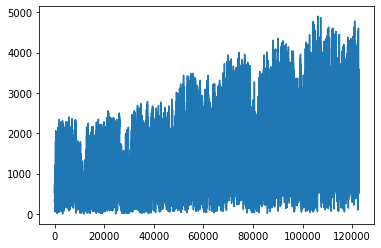

In [20]:
plt.plot(wind['Wind'])


In [21]:
solar = pd.read_csv('cleaned_solar_generation_data.csv',sep='\t')

In [22]:
solar.head()

,Date,hhmm,Solar
0,01/01/2013,00:30,0.0
1,01/01/2013,01:00,0.0
2,01/01/2013,01:30,0.0
3,01/01/2013,02:00,0.0
4,01/01/2013,02:30,0.0


In [43]:
solar['Date']=='01/01/2013'

0          True
1          True
2          True
3          True
4          True
          ...  
122683    False
122684    False
122685    False
122686    False
122687    False
Name: Date, Length: 122688, dtype: bool

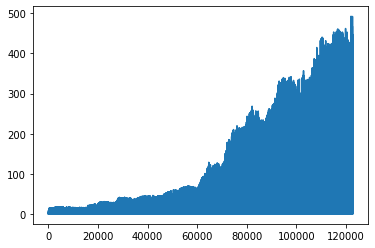

In [44]:
plt.plot(solar['Solar'])

In [63]:
avg = np.array([])
for i in range(4000,122687-4000+1):
    subsolar=np.array(solar['Solar'].iloc[i-4000:i+4000])
    avg = np.append(avg,np.max(subsolar))

In [64]:
avg.shape

(114688,)

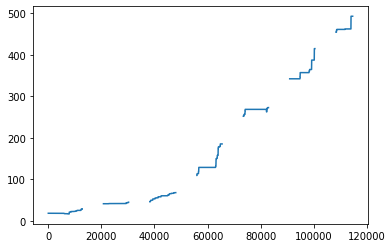

In [65]:
plt.plot(avg)

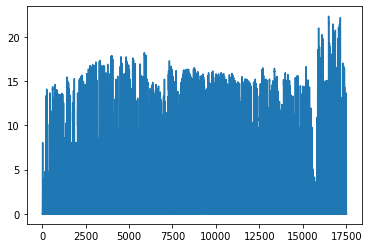

In [47]:
plt.plot(solar['Solar'][:17520])

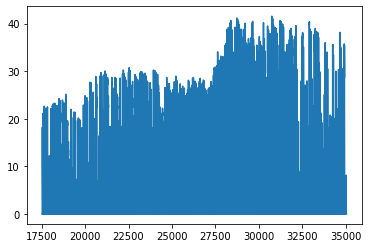

In [48]:
plt.plot(solar['Solar'][17520:35040])

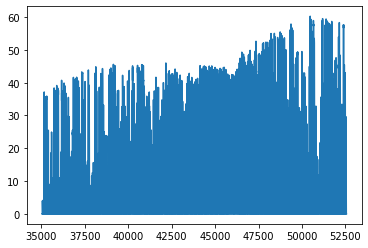

In [49]:
plt.plot(solar['Solar'][35040:52560])

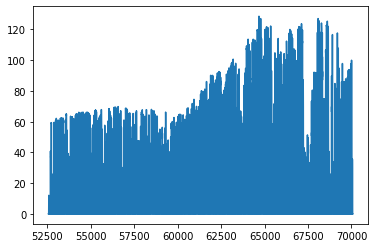

In [50]:
plt.plot(solar['Solar'][52560:70080])

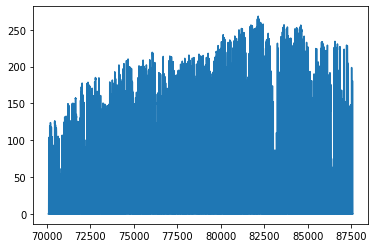

In [51]:
plt.plot(solar['Solar'][70080:87600])

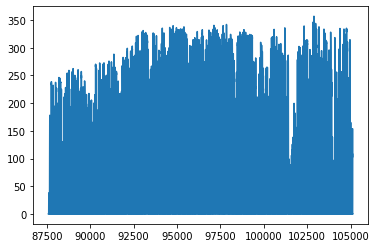

In [52]:
plt.plot(solar['Solar'][87600:105120])

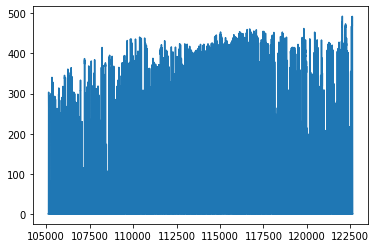

In [53]:
plt.plot(solar['Solar'][105120:122640])